In [1]:
from SimuSamp.new_funcs.load.SpatDat import SpatDat
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from SimuSamp.new_funcs.compute.n_core_sampler import sample_n_cores
from SimuSamp.new_funcs.compute.hopkins_stat import hopkins_stat
from SimuSamp.new_funcs.compute.n_neighbours import neighbours
import pingouin as pg
from astropy.stats import RipleysKEstimator
from scipy.interpolate import interp1d
import scipy.stats as stats
import ast

In [2]:
parent_filepath = "C:/Users/Michael/Desktop/block_data"
sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]
microns_per_pixel=0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

font_dict = {"fontsize": 10, "fontweight": "bold", "fontname": "Arial"}

In [ ]:
samples = []
annotation = []
hopkins = []
n_neighbour = []
densities = []
areas = []
for sample in sampleids:
    data = SpatDat(sample, parent_filepath)
    for region in ["tumour", "IM"]:
        cells = data.subset_cells(region)
        nn = np.nanmean(neighbours(cells, 1))

        anno = data.subset_annotation(region)
        area = anno.area * mm2_per_pixels2

        hopkins_statistic = hopkins_stat(anno, cells)
        
        den = len(cells) / (area)

        samples.append(sample)
        annotation.append(region)
        densities.append(den)
        areas.append(area)
        hopkins.append(hopkins_statistic)
        n_neighbour.append(nn)


ws_stats = pd.DataFrame({"sample": samples,
                         "annotation": annotation,
                         "density": densities,
                         "area_mm": areas,
                         "hopkins": hopkins,
                         "n_neighbour": n_neighbour
                         })

ws_stats.to_excel("../../../../Data/WS_stats.xlsx", index=False)

In [ ]:
ws_stats

,sample,annotation,density,area_mm,hopkins,n_neighbour
0,01_F,tumour,804.022884,198.490619,0.538817,14.494250
1,01_F,IM,815.782184,68.195900,0.542807,15.130418
2,01_G,tumour,225.027071,29.463122,0.580026,23.102434
3,01_G,IM,212.653527,35.729480,0.617608,21.936455
4,02_G,tumour,1049.946522,35.433233,0.527952,14.418908
...,...,...,...,...,...,...
65,28_FSC,IM,182.130163,48.262187,0.565168,28.368152
66,29_L,tumour,116.881187,35.001356,0.557321,33.113278
67,29_L,IM,310.231821,73.918916,0.573116,20.634262
68,30_D,tumour,122.400520,7.581667,0.587351,34.977897


## Ripley's L Function

In [3]:
def get_distances(max_dist=5000, n_steps=50, microns_per_pixel=0.22715):
    # Calculate distances for L function
    distances = np.linspace(0, max_dist / microns_per_pixel, n_steps)

    # Calculate complete spatial randomness (CSR) for Poisson process
    poisson_csr = np.pi * distances ** 2

    return distances, poisson_csr

In [4]:
def ripley_k(spatdat, region, distances, mode="ripley", frac=0.1):

    # Get cells and annotations ======================================
    cells = spatdat.subset_cells(region)
    anno = spatdat.subset_annotation(region)
    # ================================================================

    # Randomly sample 10% of cells for computation ===================
    n_sample = int(len(cells) * frac)
    coords = np.array([(p.x, p.y) for p in cells.sample(n_sample).geometry])
    # ================================================================

    # Define analysis bounds ==========================================
    x_min, y_min, x_max, y_max = anno.bounds
    kest_tum = RipleysKEstimator(area=anno.area, x_max=x_max, y_max=y_max, x_min=x_min, y_min=y_min)
    # =================================================================
    
    # Calculate L function for tumour and IM regions
    k_data = kest_tum(data=coords, radii=distances, mode=mode)

    return k_data

In [5]:
def get_intercept(k_data, distances, poisson_csr, microns_per_pixel=0.22715):

    # Interpolate intercept of L Function with with CSR
    interp = interp1d(((k_data[1:] / np.pi) ** 0.5 - distances[1:]) * microns_per_pixel, distances[1:] * microns_per_pixel, kind="nearest")

    intercept = interp(0.0)

    return intercept

In [6]:
def plot_ripley_l(k_data, distances, intercept, microns_per_pixel=0.22715):

    # Plot L Function
    plt.plot(distances * microns_per_pixel, ((k_data / np.pi) ** 0.5)  * microns_per_pixel, color="black", label="Observed Cell Distribution")

    # Plot CSR
    plt.plot(distances * microns_per_pixel, distances * microns_per_pixel, color="red", linestyle="--", label="Random Distribution")

    plt.ylim(0, 5000)
    plt.xlim(0, 5000)

    plt.gca().set_aspect("equal")

    # Plot intercept of k Function with CSR ===========================
    # Convert y-values to proportion of the y-axis
    ymax = (intercept - plt.gca().get_ylim()[0]) / (plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0])

    plt.axvline(x=intercept, color="gainsboro", linestyle="--", label=f"Intercept: {int(intercept)} \u00b5m", ymax=ymax, zorder=0)
    # =================================================================

    # Stylize plot ====================================================
    plt.xlabel("Distance (\u00b5m)", fontdict=font_dict)
    plt.ylabel("L(d)", fontdict=font_dict)

    plt.xticks(fontname="Arial", fontsize=10);
    plt.yticks(fontname="Arial", fontsize=10);

    plt.legend(prop={"size": 10, "family": "Arial"})
    # =================================================================

In [7]:
def plot_ripley_h(k_data, distances, intercept, microns_per_pixel=0.22715):

    # Plot H Function
    plt.plot(distances * microns_per_pixel, ((k_data / np.pi) ** 0.5 - distances) * microns_per_pixel, color="black", label="Observed Cell Distribution")

    # Plot CSR
    plt.axhline(y=1.0, color="red", linestyle="--", label="Random Distribution")

    plt.xlim(0, 5000)

    # Plot intercept of H Function with CSR ===========================
    # Convert y-values to proportion of the y-axis
    ymax = (0.0 - plt.gca().get_ylim()[0]) / (plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0])

    plt.axvline(x=intercept, color="gainsboro", linestyle="--", label=f"Intercept: {int(intercept)} \u00b5m", ymax=ymax, zorder=0)
    # =================================================================

    # Stylize plot ====================================================
    plt.xlabel("Distance (\u00b5m)", fontdict=font_dict)
    plt.ylabel("H(d)", fontdict=font_dict)

    plt.xticks(fontname="Arial", fontsize=10);
    plt.yticks(fontname="Arial", fontsize=10);

    plt.legend(prop={"size": 10, "family": "Arial"})
    # =================================================================

C:\Users\Michael\AppData\Local\Temp\ipykernel_15628\1225921786.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 4))


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

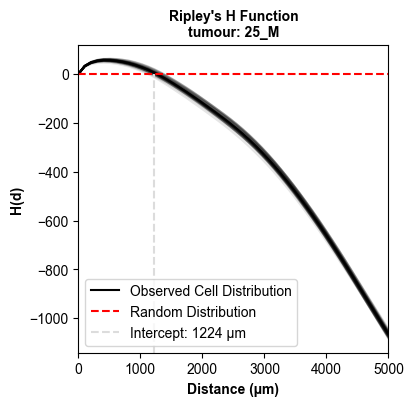

In [ ]:
sample_list = []
region_list = []
intercept_list = []
k_data_list = []
for sampleid in sampleids:

    spatdat = SpatDat(sampleid, parent_filepath)

    for region in ["tumour", "IM"]:

            distances, poisson_csr = get_distances(5000, 50)

            k_data = ripley_k(spatdat, region, distances, "ripley", frac=0.1)

            data_list = []
            for i in range(50):
                k_data = ripley_k(spatdat, region, distances, "ripley", frac=0.1)
                data_list.append(k_data)
            
            k_data = np.mean(data_list, axis=0)

            intercept = get_intercept(k_data, distances, poisson_csr)

            sample_list.append(sampleid)
            region_list.append(region)
            intercept_list.append(intercept)
            k_data_list.append(k_data)

            # Plot L Function
            plt.cla()
            plt.clf()

            fig, ax = plt.subplots(figsize=(4, 4))

            plot_ripley_l(k_data, distances, intercept)

            for data in data_list:
                plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

            # Stylize plot
            plt.title(f"Ripley's L Function\n{region}: {sampleid}", fontdict=font_dict)

            plt.savefig(f"../../../../Data/Plots/Ripleys/{sampleid}_{region}_KFunction.png", dpi=300, transparent=True, bbox_inches="tight")

            # Plot H Function
            plt.cla()
            plt.clf()

            fig, ax = plt.subplots(figsize=(4, 4))

            for data in data_list:
                plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5 - distances) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

            plot_ripley_h(k_data, distances, intercept)

            # Stylize plot
            plt.title(f"Ripley's H Function\n{region}: {sampleid}", fontdict=font_dict)

            plt.savefig(f"../../../../Data/Plots/Ripleys/{sampleid}_{region}_HFunction.png", dpi=300, transparent=True, bbox_inches="tight")

In [ ]:
ripley_stats = pd.DataFrame({"sample": sample_list,
                             "region": region_list,
                             "intercept": intercept_list,
                             "k_data": k_data_list
                             })

ripley_stats.to_excel("../../../../Data/Ripley_stats.xlsx", index=False)

## Plot Summary Statistics

In [8]:
ripley_stats = pd.read_excel("../../../../Data/Ripley_stats.xlsx")

ripley_stats["k_data"] = [np.array(ast.literal_eval(x.replace("\n", "").replace(" ", ","))) for x in ripley_stats["k_data"]]

In [9]:
ripley_tum = ripley_stats[ripley_stats["region"] == "tumour"].reset_index(drop=True)
ripley_im = ripley_stats[ripley_stats["region"] == "IM"].reset_index(drop=True)

### Plot Summary L and H Functions

In [10]:
distances, poisson_csr = get_distances(5000, 50)

ripley_tum_mean = np.mean(ripley_tum["k_data"], axis=0)
ripley_im_mean = np.mean(ripley_im["k_data"], axis=0)

tum_int = get_intercept(ripley_tum_mean, distances, poisson_csr)
im_int = get_intercept(ripley_im_mean, distances, poisson_csr)

#### L Function

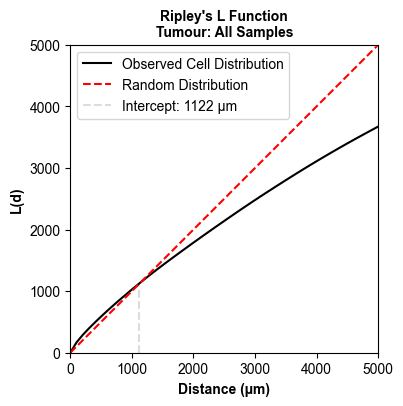

In [11]:
# Plot Tumour L Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean L Function
plot_ripley_l(ripley_tum_mean, distances, tum_int)

# Stylize plot
plt.title(f"Ripley's L Function\nTumour: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_tumour_LFunction.png", dpi=300, transparent=True, bbox_inches="tight")

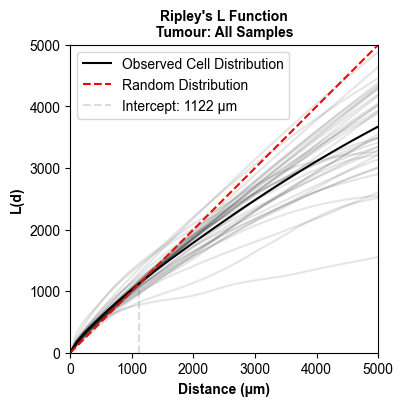

In [12]:
# Plot Tumour L Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean L Function
plot_ripley_l(ripley_tum_mean, distances, tum_int)

# Plot individual L Functions
for data in ripley_tum["k_data"]:
    plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

# Stylize plot
plt.title(f"Ripley's L Function\nTumour: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_plotted_tumour_LFunction.png", dpi=300, transparent=True, bbox_inches="tight")

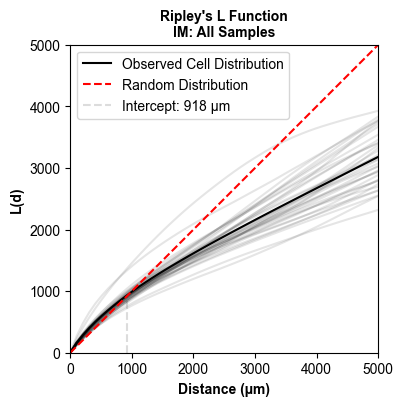

In [13]:
# Plot IM L Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean L Function
plot_ripley_l(ripley_im_mean, distances, im_int)

# Plot individual L Functions
for data in ripley_im["k_data"]:
    plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

# Stylize plot
plt.title(f"Ripley's L Function\nIM: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_plotted_IM_LFunction.png", dpi=300, transparent=True, bbox_inches="tight")

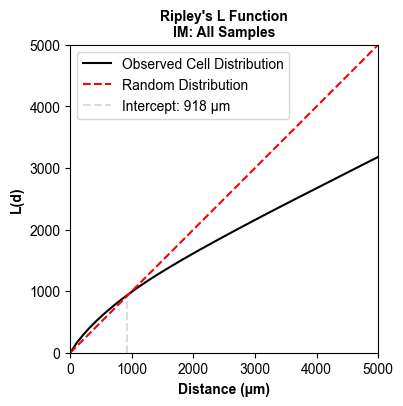

In [14]:
# Plot IM L Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean L Function
plot_ripley_l(ripley_im_mean, distances, im_int)

# Stylize plot
plt.title(f"Ripley's L Function\nIM: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_IM_LFunction.png", dpi=300, transparent=True, bbox_inches="tight")

#### H Function

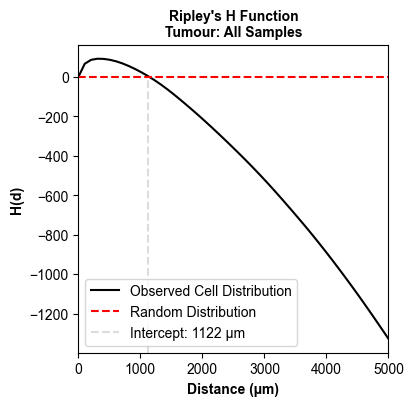

In [15]:
# Plot Tumour H Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean H Function
plot_ripley_h(ripley_tum_mean, distances, tum_int)

# Stylize plot
plt.title(f"Ripley's H Function\nTumour: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_tumour_HFunction.png", dpi=300, transparent=True, bbox_inches="tight")

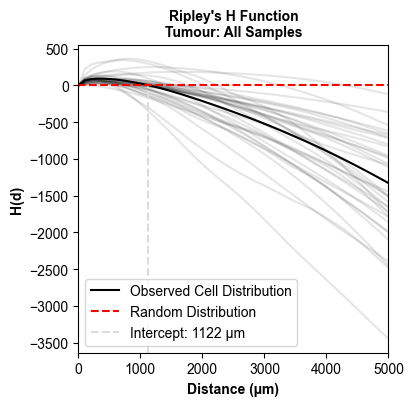

In [16]:
# Plot Tumour H Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot individual L Functions
for data in ripley_tum["k_data"]:
    plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5 - distances) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

# Plot Mean H Function
plot_ripley_h(ripley_tum_mean, distances, tum_int)

# Stylize plot
plt.title(f"Ripley's H Function\nTumour: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_plotted_tumour_HFunction.png", dpi=300, transparent=True, bbox_inches="tight")

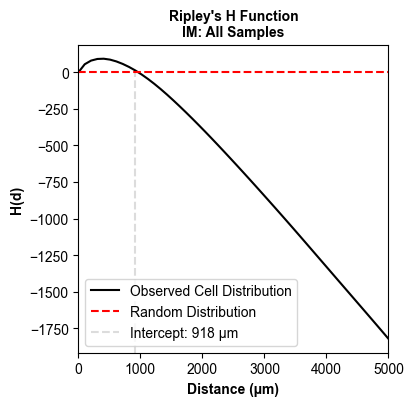

In [17]:
# Plot IM H Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot Mean H Function
plot_ripley_h(ripley_im_mean, distances, im_int)

# Stylize plot
plt.title(f"Ripley's H Function\nIM: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_IM_HFunction.png", dpi=300, transparent=True, bbox_inches="tight")

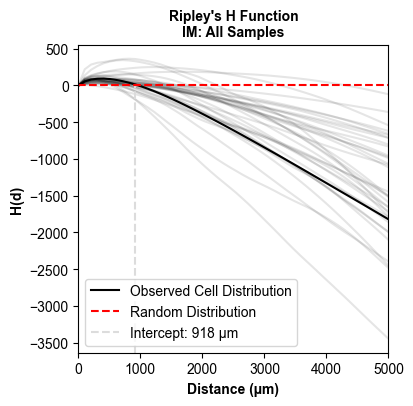

In [18]:
# Plot IM H Function

fig, ax = plt.subplots(figsize=(4, 4))

# Plot individual L Functions
for data in ripley_tum["k_data"]:
    plt.plot(distances * microns_per_pixel, ((data / np.pi) ** 0.5 - distances) * microns_per_pixel, color="black", alpha=0.1, zorder=0)

# Plot Mean H Function
plot_ripley_h(ripley_im_mean, distances, im_int)

# Stylize plot
plt.title(f"Ripley's H Function\nIM: All Samples", fontdict=font_dict)

plt.savefig(f"../../../../Data/Plots/Ripleys/allsamples_plotted_IM_HFunction.png", dpi=300, transparent=True, bbox_inches="tight")

### Plot CSR Intercept Distances for Tumour and IM

In [101]:
res = stats.wilcoxon(ripley_tum["intercept"], ripley_im["intercept"])

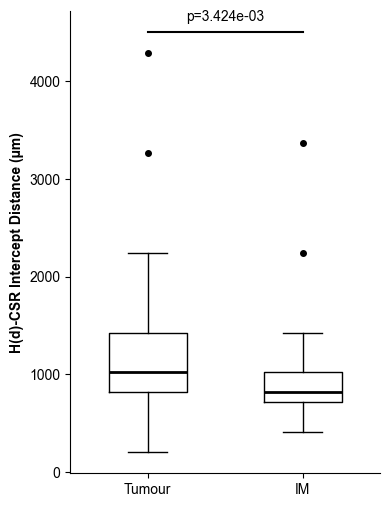

In [102]:
fig, ax = plt.subplots(figsize=(4, 6))

positions = [0, 0.6]

plt.boxplot([ripley_tum["intercept"], ripley_im["intercept"]], positions=positions, widths=0.3, tick_labels=["Tumour", "IM"], flierprops={"marker": "o", "markersize": 4, "markerfacecolor": "black"}, medianprops={"color": "black", "linewidth": 2});

xmin = -0.3
xmax = 0.9
plt.xlim(xmin, xmax)

x_min, x_max = [(x - xmin) / (xmax - xmin) for x in positions]

plt.axhline(y=ripley_stats["intercept"].max() * 1.05, color="black", xmin=x_min, xmax=x_max)
plt.text(x=0.3, y=ripley_stats["intercept"].max() * 1.07, s=f"p={res.pvalue:.3e}", ha="center", va="bottom", fontsize=10, fontname="Arial")

plt.ylabel("H(d)-CSR Intercept Distance (\u00b5m)", fontdict=font_dict);

plt.xticks(fontname="Arial", fontsize=10);
plt.yticks(fontname="Arial", fontsize=10);

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# plt.savefig("../../../../Data/Plots/Ripleys/Intercept_Boxplot.png", dpi=300, transparent=True, bbox_inches="tight")